In [1]:
import datetime
start_time = datetime.datetime.now()

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from metamux.classification import segment_feature_union
from metamux.classification.features import util, differential
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import datetime
from tools import make_name, save_infos
import recordings_paths

from rename_labels import label_dict # dict with names for labels (Schrauben, Stift rein,...)
from rename_labels import get_opposites_out, merge_variants_screw_lr, merge_variants_screw_abc
import recordings_paths # for filling DataLoader
from plot_data import plot_slot, make_cm_all, make_cm_tt # to plot line-plots and cm_plot from JH
from plot_data import plot_precisions, plot_precisions_old
from data_prep import prep_data, select_sensor_channel

In [3]:
sensors_lists = ['dist pos'.split(), 'acc gyro'.split(), 'dist pos acc gyro'.split()]
sensors_list = sensors_lists[2]

merge_opposites = False
merge_screw_lr = False
merge_screw_abc = False

with_date = False

fuse_slots = None
slot_filling=False

name=None
with_date=True # add timestamp to name

show_time=False
show_dots=False
debug=False
deep_debug=False

In [4]:
###################################################
#                                                 #
#                   PIPELINE                      #
#                                                 #
###################################################

In [5]:
import all_pipes
from all_pipes import pipes_feat, get_pipes

pipes = get_pipes(pipes_feat)

In [ ]:
klass_index = 1
pipes_diff_index = 3
pipe_stat_index = 1

In [6]:
pipe = pipes[klass_index][pipes_diff_index][pipe_stat_index]

In [7]:
pipe

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('pipe_stat', Pipeline(memory=None,
     steps=[('differential', SegmentFeatureUnion(n_jobs=1,
          transformer_list=[('identity', SegmentFunctionTransformer(func=None, func_kwargs=None)), ('diff', SegmentDiffTransformer()),...None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

In [8]:
pipe_stat = pipe
pipe_all = pipe_stat.steps[0][1].transformer_list[0][1]

diff_features = pipe_all.steps[0][1].transformer_list
diff_features_list = [diff_feature[0] for diff_feature in diff_features]

stat_features = pipe_all.steps[1][1].transformer_list
stat_features_list = [stat_feature[0] for stat_feature in stat_features]

In [9]:
###################################################
#                                                 #
#                  PREP DATA                      #
#                                                 #
###################################################

prep_start_time = datetime.datetime.now()

subjects = 'all10'

if debug: print('got name {}'.format(name))
#if name is None:
name = make_name(subjects=subjects, sensors_list=sensors_list,
                 diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                 fuse_slots=fuse_slots,
                 merge_opposites=merge_opposites,
                 merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                 with_date=with_date,
                 show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)
if debug: print('name = {}'.format(name))

loader = recordings_paths.fill_loader(debug=debug)

if subjects == 'all':
    subjects = 'JP10,MM,AR,MJ,CA,CD,JH10'
elif subjects == 'all10':
    subjects = 'JP10,MM,AR,MJ,CD,JH10'
    
subjects = subjects.split(',')  # making list with subjects names
path_list = loader.get_data(subjects, debug=debug, deep_debug=deep_debug)  # get paths for subjects

In [29]:
###################################################
#                                                 #
#                   GET DATA                      #
#                                                 #
###################################################

# train_subjects = 'MM_AR_MJ_CD_JH10'
# test_subjects = 'JP10'
# # now make subjects into list
# train_subjects = train_subjects.split('_')  # making list with train_subjects names
# test_subjects = test_subjects.split('_')  # making list with train_subjects names
# 
# if debug: print('train_subjects = {}'.format(train_subjects))
# if debug: print('test_subjects = {}'.format(test_subjects))

sensors_lists = ['dist pos'.split(), 'acc gyro'.split(), 'dist pos acc gyro'.split()]
sensors_list = sensors_lists[2]

# prep_start_time = datetime.datetime.now()
# print('Start time = {}'.format(prep_start_time))

# print('Prepare data for {}'.format(sensors_list))

In [11]:
# data und targets für subject und sensors_list holen
sessions, targets, concat_data, concat_targets, worked_with = prep_data(path_list=path_list, sensors_list=None, 
                                                                        fuse_slots=fuse_slots, slot_filling=slot_filling, 
                                                                        show_time=True, show_dots=True, 
                                                                        debug=debug, deep_debug=deep_debug)

Start time = 2019-05-16 12:23:39.720804
............................................................
data prep duration = 0:00:51.587226


In [12]:
all_data_fus = [slot.values for session in sessions for slot in session]

all_data_kin = [slot.iloc[:,:7].values for session in sessions for slot in session]

all_data_imu = [slot.iloc[:,7:].values for session in sessions for slot in session]

In [13]:
groups = [path[23:25] for path in worked_with]
groups_long = []
for p_index, path in enumerate(groups):
    for i in range(len(sessions[p_index])):
        groups_long.append(path)

In [14]:
# get labels out
if not merge_opposites:
    # concat_targets_noopp = [get_opposites_out[l] for l in concat_targets]
    concat_targets = [get_opposites_out[l] for l in concat_targets]
    if debug: print('get opposites out')
if merge_screw_lr:
    #concat_targets_abc = [merge_variants_screw_lr[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_lr[l] for l in concat_targets]
    if debug: print('merge lr')
if merge_screw_abc:
    #concat_targets_lr = [merge_variants_screw_abc[l] for l in concat_targets]
    concat_targets = [merge_variants_screw_abc[l] for l in concat_targets] # TODO ---- auch für do_it_ud!!!!!!
    if debug: print('merge abc')

In [15]:
###################################################
#                                                 #
#                CLASSIFICATION                   #
#                                                 #
###################################################

In [16]:
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, LeaveOneOut
cv = LeaveOneGroupOut()
cv_fus = cv.split(all_data_fus, concat_targets, groups=groups_long)

In [17]:
# make one array with all segments and targets
debug = True
all_data_fus_ar = np.array(all_data_fus)
#if debug: len(all_data_fus_ar[test])
    
concat_targets_ar = np.array(concat_targets)
if debug: type(concat_targets)

In [18]:
predicted_fus = []
backup_targets = []

In [19]:
import sklearn
from sklearn.metrics import accuracy_score

In [21]:
accs = [[[[[] for _ in range(3)] for _ in range(6)] for _ in range(6)] for _ in range(6)]

pipe_indices = str(klass_index) + str(pipes_diff_index) + str(pipe_stat_index)

klassis = ''
for step_index, step in enumerate(pipe_stat.steps):
    if step_index == 0: continue
    if step_index == 2: klassis = klassis + '_'
    klassis = klassis + str(step[0])

all_data_kin_ar = np.array(all_data_kin)
all_data_imu_ar = np.array(all_data_imu)
all_data_fus_ar = np.array(all_data_fus)

In [22]:
# groups # MM, JP, AR, MJ, JH, CD

In [23]:
mode = ''
if not merge_opposites:
    mode = mode + ' no_opp'
if merge_screw_lr:
    mode = mode + ' abc'
if merge_screw_abc:
    mode = mode + '  lr'
if fuse_slots is not None:
    mode = mode + ' ' + str(fuse_slots[2])

In [24]:
mode = ''

In [28]:
sensors_lists

[['dist', 'pos', 'acc', 'gyro']]

69.52 85.24 88.57
subjects = AR
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


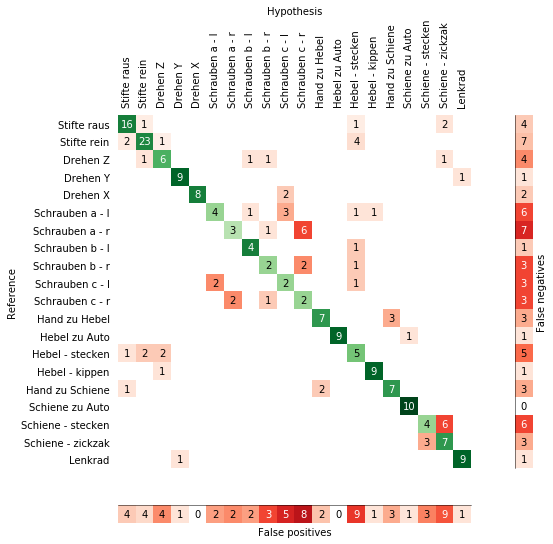

Accuracy = 69.52380952380952
Mode = plots/AR_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123002
---train_subjects = None
subjects = AR
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


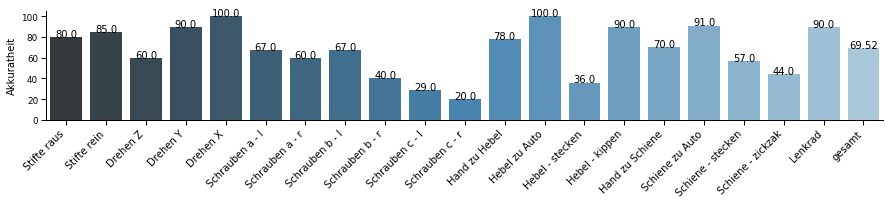

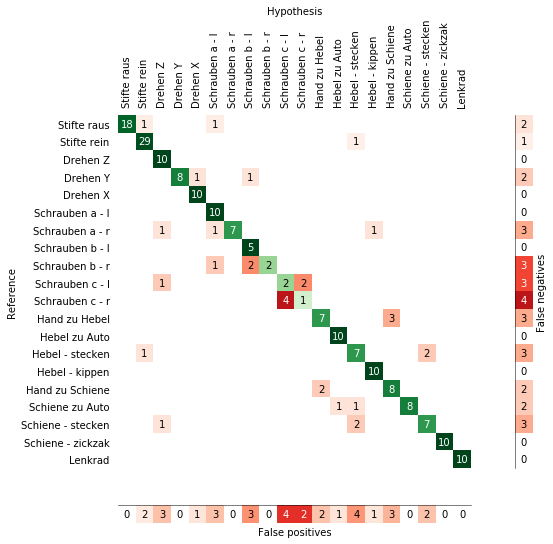

Accuracy = 85.23809523809524
Mode = plots/AR_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123007
---train_subjects = None
subjects = AR
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


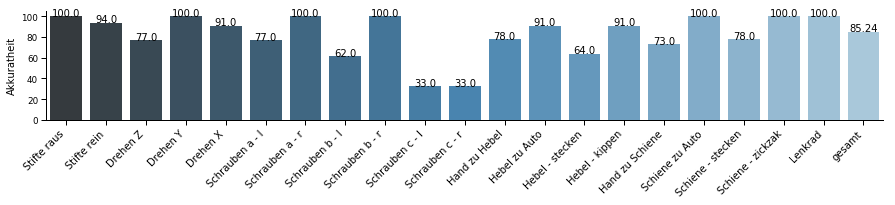

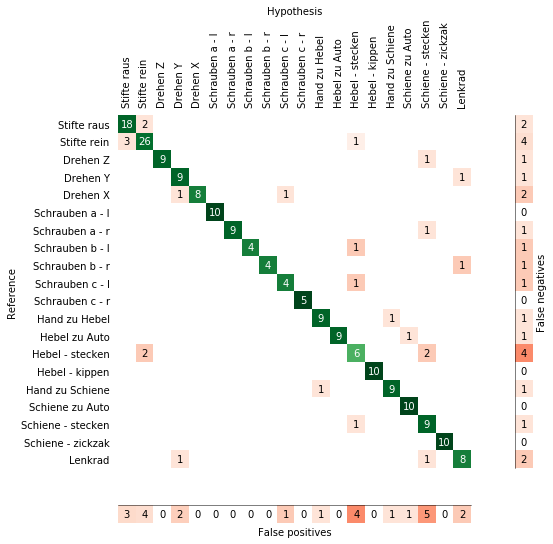

Accuracy = 88.57142857142857
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
65.24 81.43 86.67
subjects = CD
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


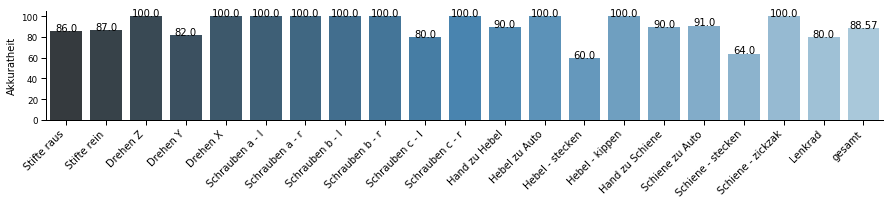

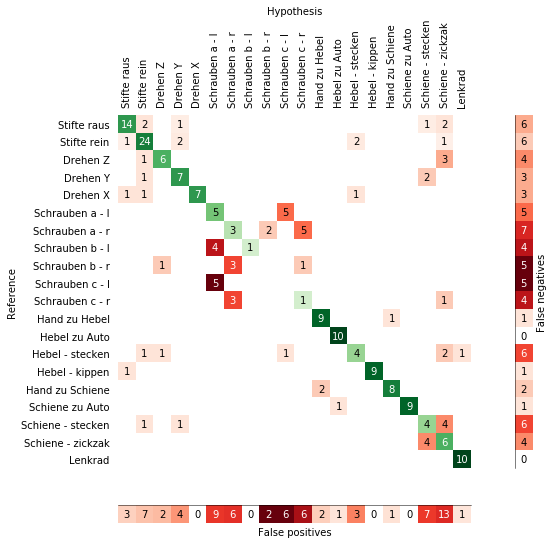

Accuracy = 65.23809523809524
Mode = plots/CD_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123030
---train_subjects = None
subjects = CD
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


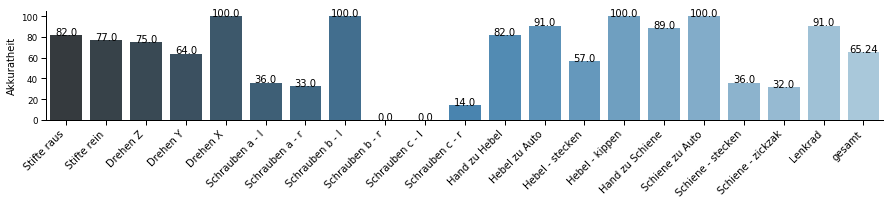

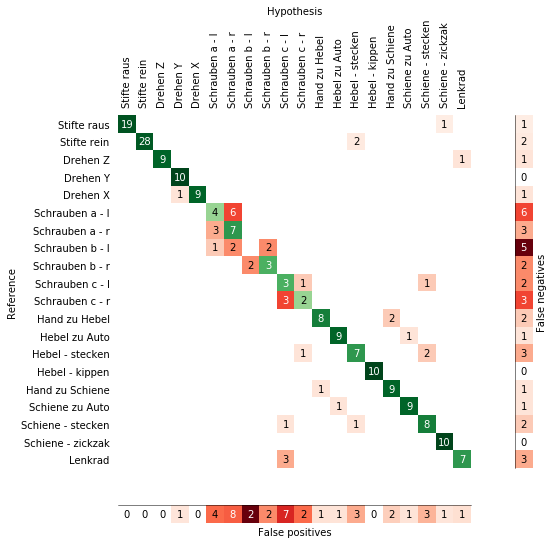

Accuracy = 81.42857142857143
Mode = plots/CD_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123034
---train_subjects = None
subjects = CD
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


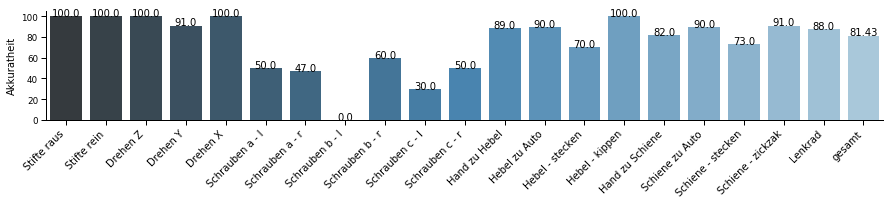

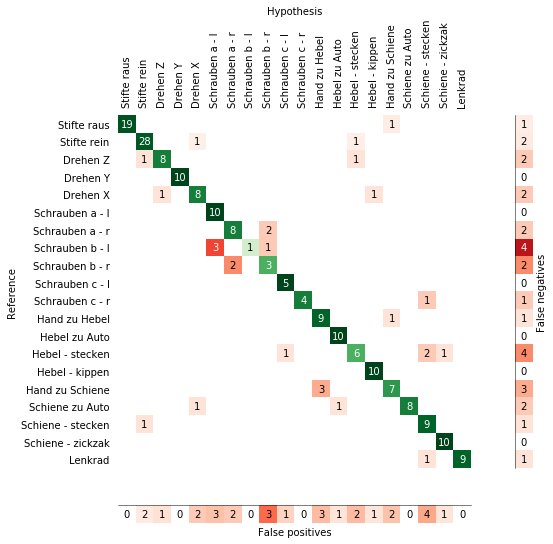

Accuracy = 86.66666666666667
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
71.43 92.38 89.52
subjects = JH
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


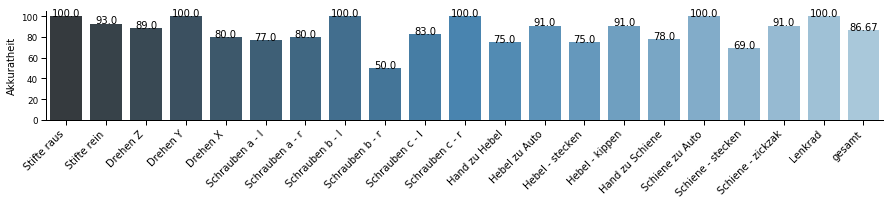

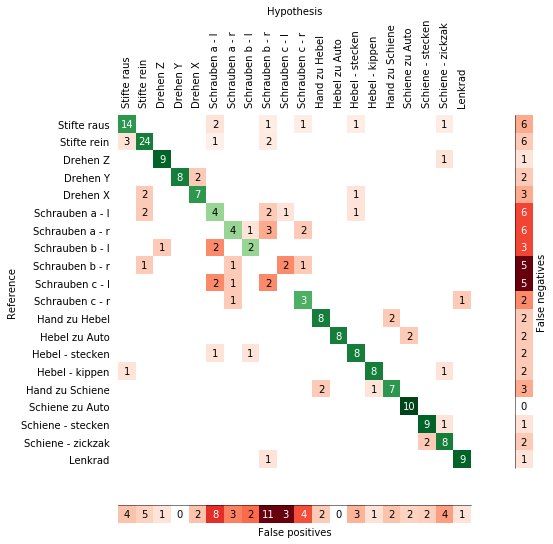

Accuracy = 71.42857142857143
Mode = plots/JH_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123058
---train_subjects = None
subjects = JH
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


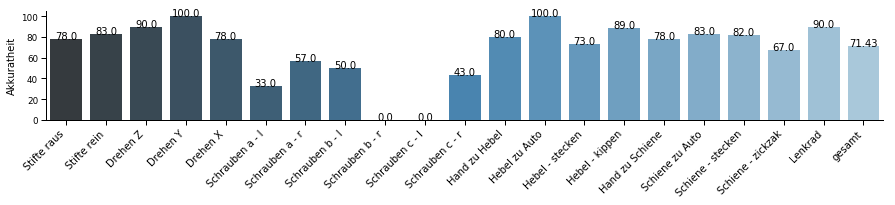

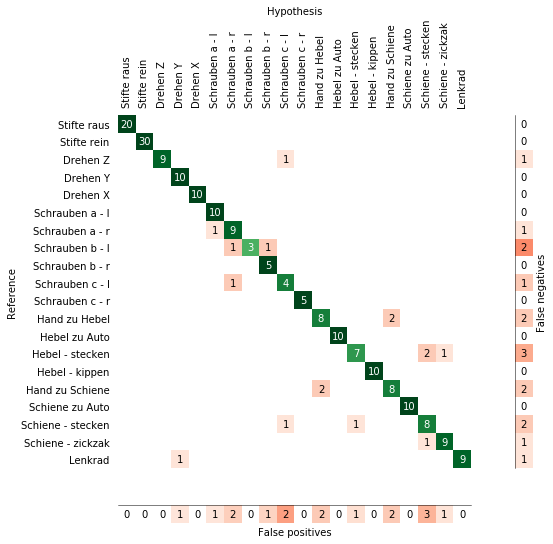

Accuracy = 92.38095238095238
Mode = plots/JH_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123101
---train_subjects = None
subjects = JH
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


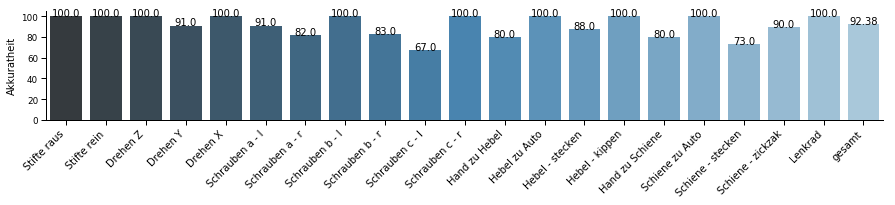

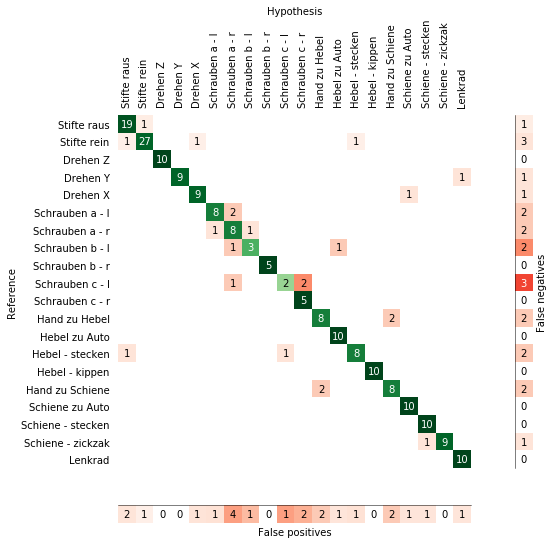

Accuracy = 89.52380952380953
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
79.52 90.0 94.76
subjects = JP
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


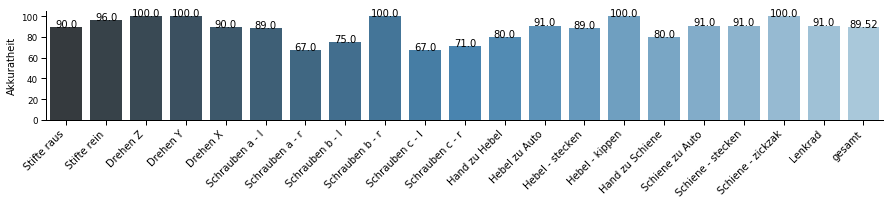

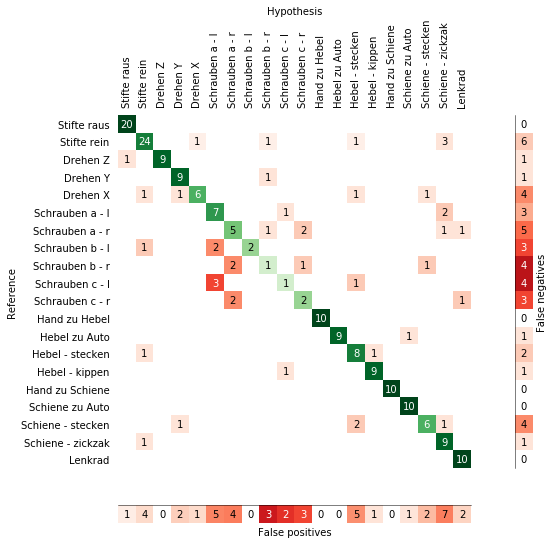

Accuracy = 79.52380952380952
Mode = plots/JP_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123123
---train_subjects = None
subjects = JP
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


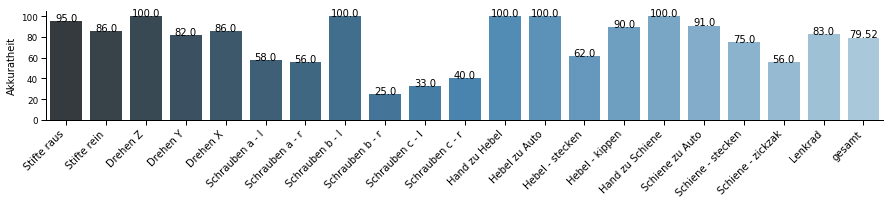

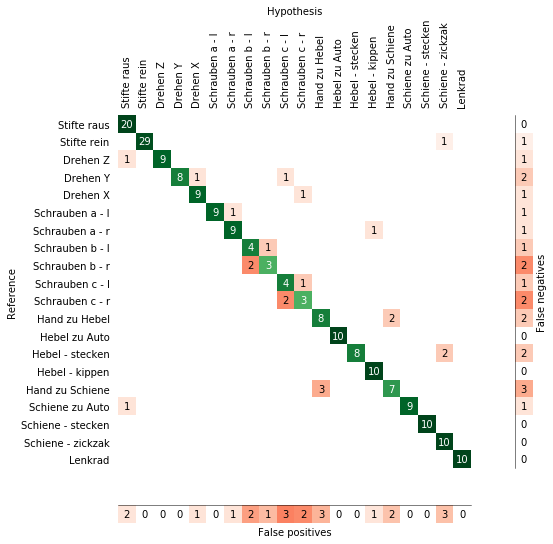

Accuracy = 90.0
Mode = plots/JP_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123127
---train_subjects = None
subjects = JP
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


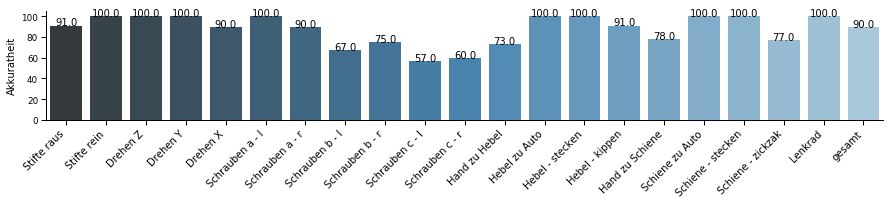

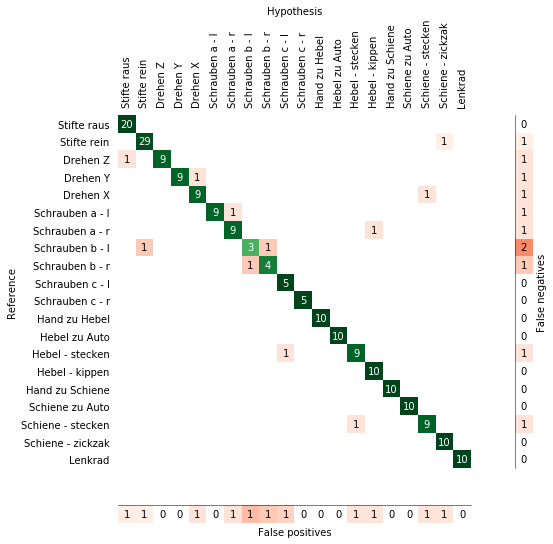

Accuracy = 94.76190476190476
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
72.38 82.38 82.86
subjects = MJ
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


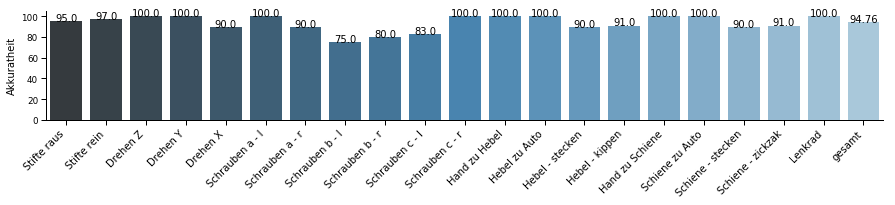

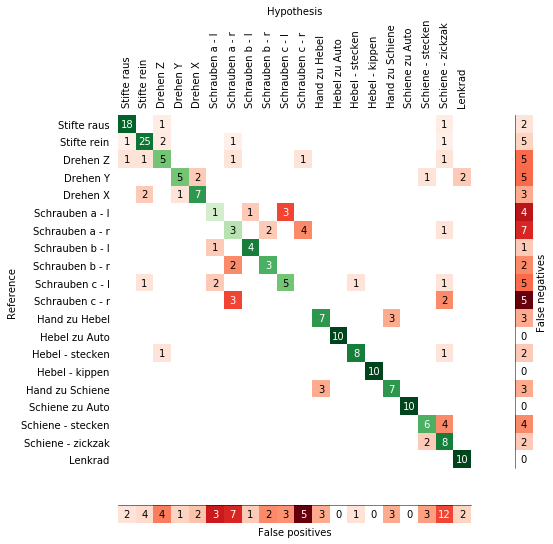

Accuracy = 72.38095238095238
Mode = plots/MJ_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123151
---train_subjects = None
subjects = MJ
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


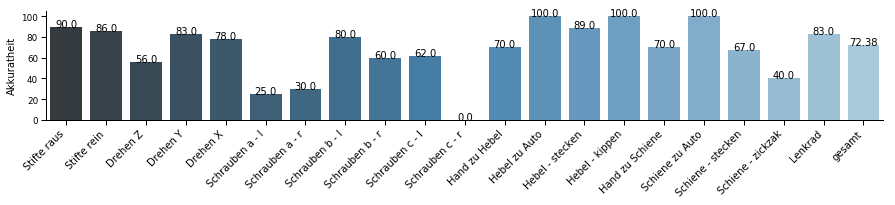

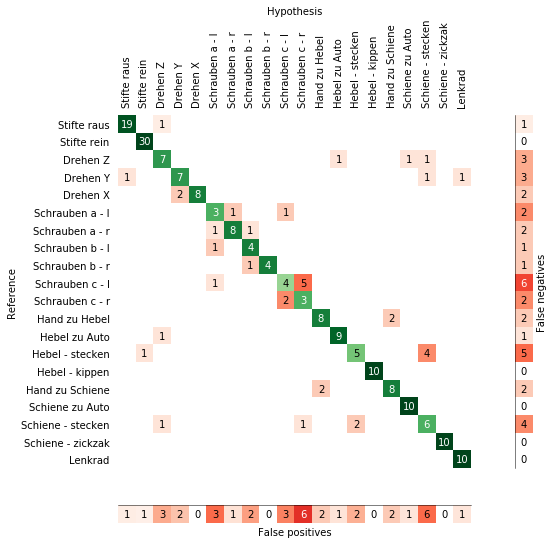

Accuracy = 82.38095238095238
Mode = plots/MJ_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123155
---train_subjects = None
subjects = MJ
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


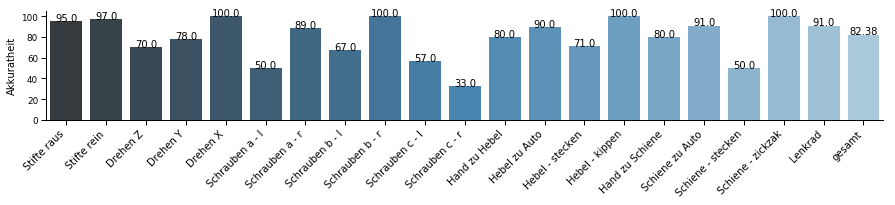

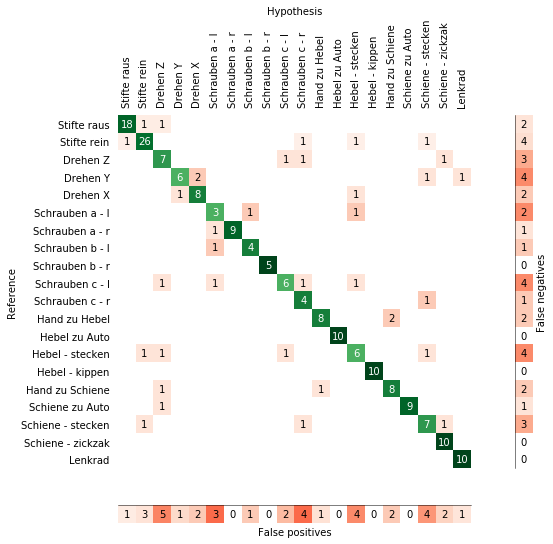

Accuracy = 82.85714285714286
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
53.43 88.24 88.73
subjects = MM
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


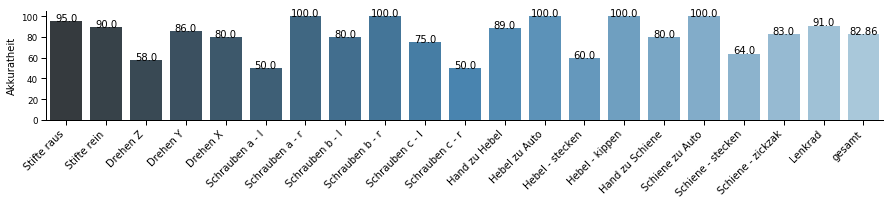

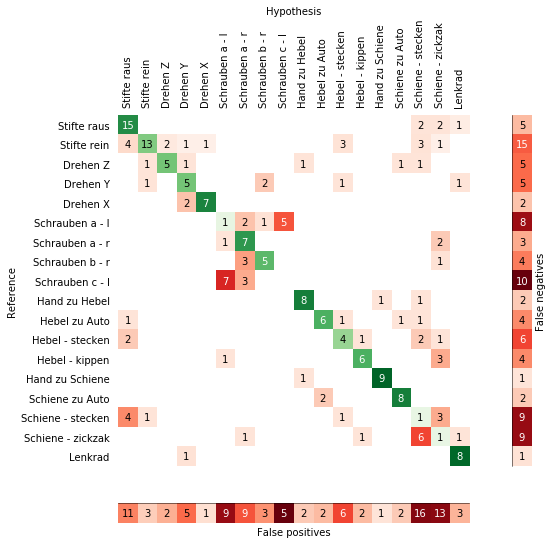

Accuracy = 53.431372549019606
Mode = plots/MM_kinect_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123216
---train_subjects = None
subjects = MM
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


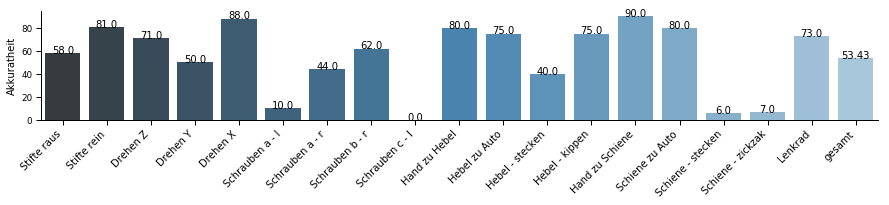

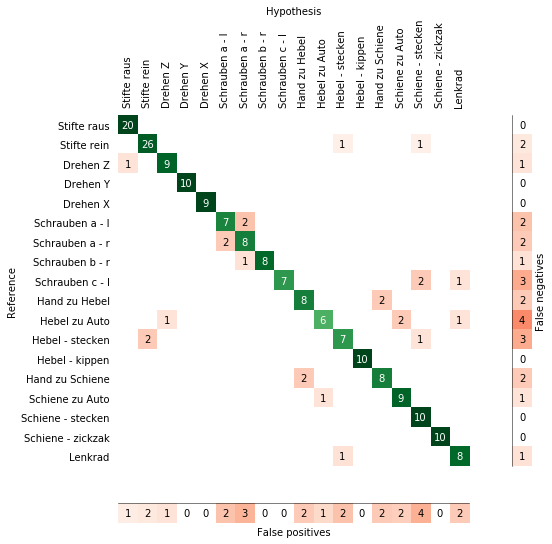

Accuracy = 88.23529411764706
Mode = plots/MM_imu_131_lda_identity_diff_int1_min_max_mean_noops_20190516-123220
---train_subjects = None
subjects = MM
Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


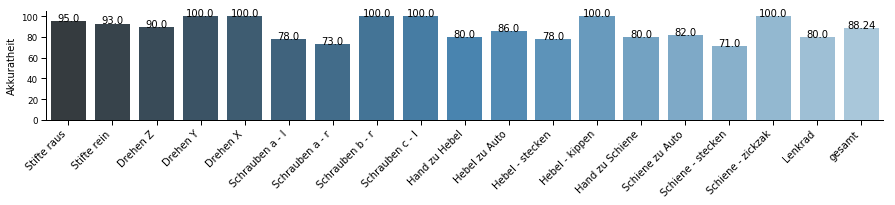

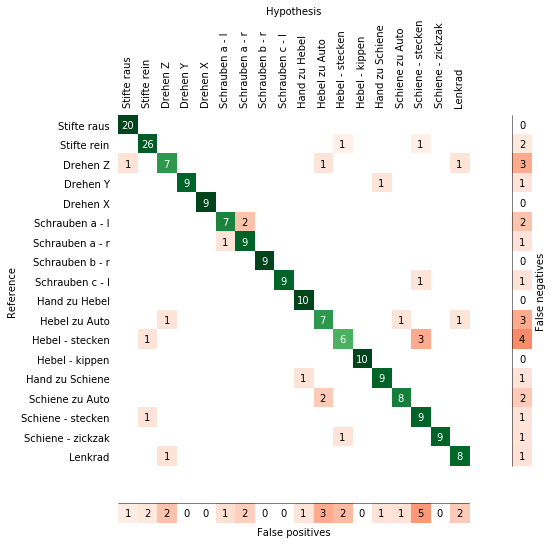

Accuracy = 88.72549019607843
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339
---train_subjects = None
------------------------------
131 68.6602870813397 86.60287081339713 88.51674641148325


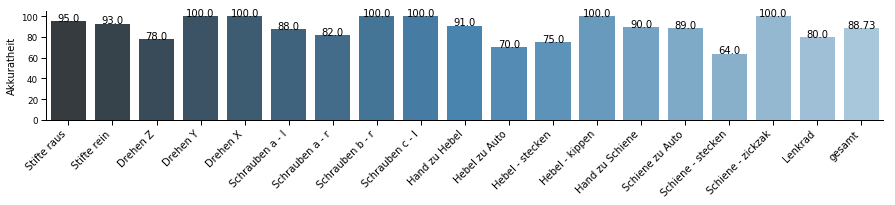

In [30]:
predicted_kin = []
predicted_imu = []
predicted_fus = []

backup_targets = [] # original ones seem to not work... i dont know why

ud_precisions = []

import sklearn
from sklearn.metrics import accuracy_score

cv = LeaveOneGroupOut()

# shouldnt make a difference that split is done on all_data_fus but split is used for kin, imu and fus, 
# because we only use the indices anyway and get data fresh
for train, test in cv.split(all_data_fus, concat_targets, groups=groups_long): # for all subjects
    # print(len(test))
    
    if np.array(groups_long)[test][0] == np.array(groups_long)[test][-1]:
        temp_subject = np.array(groups_long)[test][0]
    
    # TODO concat_targets_ar erst hier machen?
    
    one_predicted_kin = cross_val_predict(pipe_stat, all_data_kin_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
    one_predicted_imu = cross_val_predict(pipe_stat, all_data_imu_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
    one_predicted_fus = cross_val_predict(pipe_stat, all_data_fus_ar[test], concat_targets_ar[test], cv=LeaveOneOut())
    
    one_accuracy_kin = round(accuracy_score(concat_targets_ar[test], one_predicted_kin) * 100, 2)
    one_accuracy_imu = round(accuracy_score(concat_targets_ar[test], one_predicted_imu) * 100, 2)
    one_accuracy_fus = round(accuracy_score(concat_targets_ar[test], one_predicted_fus) * 100, 2)
    
    print(one_accuracy_kin, one_accuracy_imu, one_accuracy_fus)
    ud_precisions.append([one_accuracy_kin, one_accuracy_imu, one_accuracy_fus])
    
    schriftgroesse = 10
    import seaborn as sns
    sns.set_context("paper", rc={"font.size": schriftgroesse, "axes.titlesize": schriftgroesse, "axes.labelsize": schriftgroesse})

    # ------------------ KIN
    predicted_kin.append(one_predicted_kin)
    
    name_kin = make_name(subjects=temp_subject, sensors_list=sensors_lists[0],
                     pipe= pipe_indices, klassifikator=klassis,
                     diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                     fuse_slots=fuse_slots,
                     merge_opposites=merge_opposites,
                     merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                     with_date=with_date,
                     show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)
    
    make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                worked_with, subjects, concat_targets_ar[test], one_predicted_kin, label_dict, name_kin)
    
    report_kin = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_kin)
    
    plot_precisions(report_kin, schriftgroesse, name=name_kin, acc=one_accuracy_kin)
    save_infos(sensors_list=sensors_lists[0], pipe= pipe_indices, klassifikator=klassis,
               diff_features_list=diff_features_list, stat_features_list=stat_features_list,
               path_list=worked_with, subjects=subjects,
               targets=concat_targets_ar[test], predicted=one_predicted_kin,
               rename=label_dict, name=name_kin)
    
    # ------------------ IMU 
    predicted_imu.append(one_predicted_imu)
    
    name_imu = make_name(subjects=temp_subject, sensors_list=sensors_lists[1],
                     pipe= pipe_indices, klassifikator=klassis,
                     diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                     fuse_slots=fuse_slots,
                     merge_opposites=merge_opposites,
                     merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                     with_date=with_date,
                     show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)
    
    make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                worked_with, subjects, concat_targets_ar[test], one_predicted_imu, label_dict, name_imu)
    
    report_imu = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_imu)
    
    plot_precisions(report_imu, schriftgroesse, name=name_imu, acc=one_accuracy_imu)
    save_infos(sensors_list=sensors_lists[1], pipe= pipe_indices, klassifikator=klassis,
               diff_features_list=diff_features_list, stat_features_list=stat_features_list,
               path_list=worked_with, subjects=subjects,
               targets=concat_targets_ar[test], predicted=one_predicted_imu,
               rename=label_dict, name=name_imu)
    
    # ------------------ FUS    
    predicted_fus.append(one_predicted_fus)
    
    name_fus = make_name(subjects=temp_subject, sensors_list=sensors_lists[2],
                     pipe= pipe_indices, klassifikator=klassis,
                     diff_features_list=diff_features_list, stat_features_list=stat_features_list,
                     fuse_slots=fuse_slots,
                     merge_opposites=merge_opposites,
                     merge_screw_lr=merge_screw_lr, merge_screw_abc=merge_screw_abc,
                     with_date=with_date,
                     show_time=show_time, show_dots=show_dots, debug=debug, deep_debug=deep_debug)
    
    make_cm_all(sensors_list, diff_features_list, stat_features_list, 
                worked_with, subjects, concat_targets_ar[test], one_predicted_fus, label_dict, name)
    
    report_fus = sklearn.metrics.classification_report(concat_targets_ar[test], one_predicted_fus)
    
    plot_precisions(report_fus, schriftgroesse, name=name_fus, acc=one_accuracy_fus)
    save_infos(sensors_list=sensors_lists[2], pipe= pipe_indices, klassifikator=klassis,
               diff_features_list=diff_features_list, stat_features_list=stat_features_list,
               path_list=worked_with, subjects=subjects,
               targets=concat_targets_ar[test], predicted=one_predicted_fus,
               rename=label_dict, name=name_fus)
    
    # ----------------- all

    backup_targets.append(concat_targets_ar[test])

X_kin = ([j for i in predicted_kin for j in i])
X_imu = ([j for i in predicted_imu for j in i])
X_fus = ([j for i in predicted_fus for j in i])
Y = ([j for i in backup_targets for j in i])

print('-'*30)

print(pipe_indices, accuracy_score(Y, X_kin) * 100, accuracy_score(Y, X_imu) * 100, accuracy_score(Y, X_fus) * 100) 

In [31]:
ud_precisions

[[69.52, 85.24, 88.57],
 [65.24, 81.43, 86.67],
 [71.43, 92.38, 89.52],
 [79.52, 90.0, 94.76],
 [72.38, 82.38, 82.86],
 [53.43, 88.24, 88.73]]

In [32]:
X = ([j for i in predicted_fus for j in i])
Y = ([j for i in backup_targets for j in i])

In [ ]:
acc

In [33]:
accuracy_score(Y, X) * 100

88.51674641148325

In [35]:
name

'plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339'

Analysed sensors: , dist, pos, acc, gyro
Differential features: , identity, diff, int1 - Statistical features: , min, max, mean
Number of Sessions = 60
Subjects = , JP10, MM, AR, MJ, CD, JH10


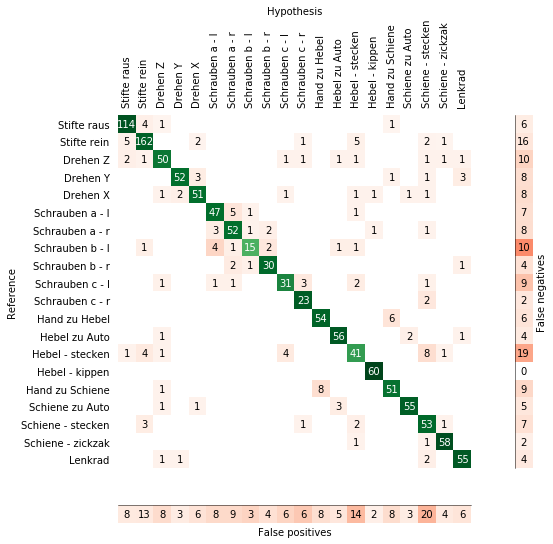

Accuracy = 88.51674641148325
Mode = plots/all10_fusion_identity_diff_int1_min_max_mean_noops_20190516-122339


<Figure size 432x288 with 0 Axes>

In [34]:
make_cm_all(sensors_list, diff_features_list, stat_features_list, worked_with, subjects, Y, X,
            label_dict, name)